In [ ]:
!pip install pyspark

Import Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator

Load Data

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName("CovidDetection").getOrCreate()

# Load data
covid_data = spark.read.csv("Covid Dataset.csv", header=True, inferSchema=True)

Display Data

In [ ]:
covid_data.show()

+-----------------+-----+---------+-----------+------------+------+--------------------+--------+-------------+--------+-------------+--------+-----------------+-------------+--------------------------+------------------------+-----------------------------+---------------------------------------+-------------+------------------------+--------+
|Breathing Problem|Fever|Dry Cough|Sore throat|Running Nose|Asthma|Chronic Lung Disease|Headache|Heart Disease|Diabetes|Hyper Tension|Fatigue |Gastrointestinal |Abroad travel|Contact with COVID Patient|Attended Large Gathering|Visited Public Exposed Places|Family working in Public Exposed Places|Wearing Masks|Sanitization from Market|COVID-19|
+-----------------+-----+---------+-----------+------------+------+--------------------+--------+-------------+--------+-------------+--------+-----------------+-------------+--------------------------+------------------------+-----------------------------+---------------------------------------+-----------

Print Data Shape

In [ ]:
# Number of rows
num_rows = covid_data.count()

# Number of columns
num_columns = len(covid_data.columns)

# Display the shape
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")


Number of rows: 5434, Number of columns: 21


Display the features

In [ ]:
# Display the column names (features)
feature_columns = covid_data.columns
print("Features: \n")
for column in feature_columns:
    print(column)

Features: 

Breathing Problem
Fever
Dry Cough
Sore throat
Running Nose
Asthma
Chronic Lung Disease
Headache
Heart Disease
Diabetes
Hyper Tension
Fatigue 
Gastrointestinal 
Abroad travel
Contact with COVID Patient
Attended Large Gathering
Visited Public Exposed Places
Family working in Public Exposed Places
Wearing Masks
Sanitization from Market
COVID-19


Display data types and nullable information

In [ ]:
# Display DataFrame schema
covid_data.printSchema()


root
 |-- Breathing Problem: string (nullable = true)
 |-- Fever: string (nullable = true)
 |-- Dry Cough: string (nullable = true)
 |-- Sore throat: string (nullable = true)
 |-- Running Nose: string (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- Chronic Lung Disease: string (nullable = true)
 |-- Headache: string (nullable = true)
 |-- Heart Disease: string (nullable = true)
 |-- Diabetes: string (nullable = true)
 |-- Hyper Tension: string (nullable = true)
 |-- Fatigue : string (nullable = true)
 |-- Gastrointestinal : string (nullable = true)
 |-- Abroad travel: string (nullable = true)
 |-- Contact with COVID Patient: string (nullable = true)
 |-- Attended Large Gathering: string (nullable = true)
 |-- Visited Public Exposed Places: string (nullable = true)
 |-- Family working in Public Exposed Places: string (nullable = true)
 |-- Wearing Masks: string (nullable = true)
 |-- Sanitization from Market: string (nullable = true)
 |-- COVID-19: string (nullable = true)


Get summary statistics of numeric columns

In [ ]:
# Get summary statistics and transpose
summary_statistics = covid_data.describe().toPandas().transpose()

# Display the transposed summary statistics
print(summary_statistics)


                                             0     1       2    3    4
summary                                  count  mean  stddev  min  max
Breathing Problem                         5434  None    None   No  Yes
Fever                                     5434  None    None   No  Yes
Dry Cough                                 5434  None    None   No  Yes
Sore throat                               5434  None    None   No  Yes
Running Nose                              5434  None    None   No  Yes
Asthma                                    5434  None    None   No  Yes
Chronic Lung Disease                      5434  None    None   No  Yes
Headache                                  5434  None    None   No  Yes
Heart Disease                             5434  None    None   No  Yes
Diabetes                                  5434  None    None   No  Yes
Hyper Tension                             5434  None    None   No  Yes
Fatigue                                   5434  None    None   No  Yes
Gastro

Display the percentage of missing values

In [ ]:
# Calculate missing values and percentage
missing_values = covid_data.agg(*[
    (1 - (F.count(col(c)) / F.count("*"))).alias(c + '_missing_percent')
    for c in covid_data.columns
])

# Display the result
missing_values.show()


+---------------------------------+---------------------+-------------------------+---------------------------+----------------------------+----------------------+------------------------------------+------------------------+-----------------------------+------------------------+-----------------------------+------------------------+---------------------------------+-----------------------------+------------------------------------------+----------------------------------------+---------------------------------------------+-------------------------------------------------------+-----------------------------+----------------------------------------+------------------------+
|Breathing Problem_missing_percent|Fever_missing_percent|Dry Cough_missing_percent|Sore throat_missing_percent|Running Nose_missing_percent|Asthma_missing_percent|Chronic Lung Disease_missing_percent|Headache_missing_percent|Heart Disease_missing_percent|Diabetes_missing_percent|Hyper Tension_missing_percent|Fatigue 

Visualize the count of Covid Cases

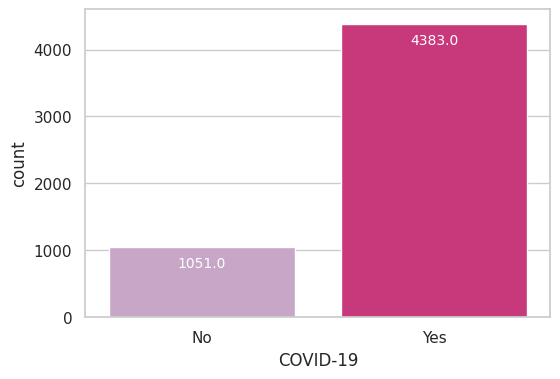

In [ ]:
# Assuming 'COVID-19' is a binary column with values 0 and 1
covid_count = covid_data.groupBy('COVID-19').count().toPandas()

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='COVID-19', y='count', data=covid_count, palette="PuRd")

# Annotate each bar with the count value
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height() + 100),
                ha='center', va='top', color='white', size=10)

plt.show()


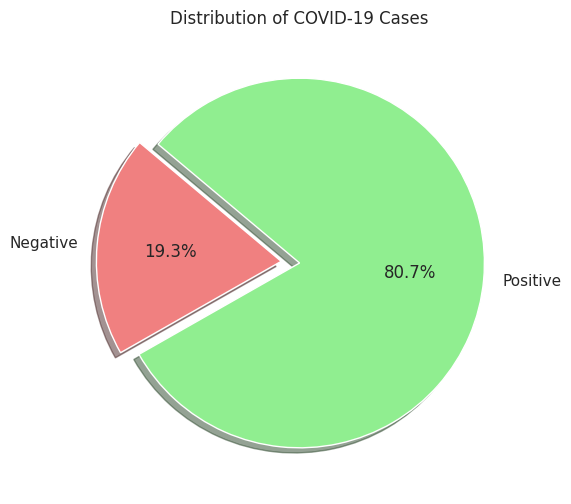

In [ ]:
# Assuming 'COVID-19' is a binary column with values 0 and 1
covid_counts = covid_data.groupBy('COVID-19').count().toPandas()

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(6, 6))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Negative', 'Positive']
sizes = covid_counts['count']
explode = (0.1, 0)  # explode the 1st slice

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=140, colors=['lightcoral', 'lightgreen'])
plt.title('Distribution of COVID-19 Cases')

plt.show()

Label Encoding

In [ ]:
# Data preprocessing
label_columns = ['Breathing Problem', 'Fever', 'Dry Cough', 'Sore throat', 'Running Nose',
                  'Asthma', 'Chronic Lung Disease', 'Headache', 'Heart Disease', 'Diabetes',
                  'Hyper Tension', 'Fatigue ', 'Gastrointestinal ', 'Abroad travel',
                  'Contact with COVID Patient', 'Attended Large Gathering',
                  'Visited Public Exposed Places', 'Family working in Public Exposed Places',
                  'Wearing Masks', 'Sanitization from Market', 'COVID-19']

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in label_columns]

pipeline = Pipeline(stages=indexers)
covid_data = pipeline.fit(covid_data).transform(covid_data)

In [ ]:
# Drop original categorical columns
columns_to_drop = label_columns
covid_data = covid_data.drop(*columns_to_drop)

In [ ]:
# Show the transformed DataFrame
covid_data.show()

+-----------------------+-----------+---------------+-----------------+------------------+------------+--------------------------+--------------+-------------------+--------------+-------------------+--------------+-----------------------+-------------------+--------------------------------+------------------------------+-----------------------------------+---------------------------------------------+-------------------+------------------------------+--------------+
|Breathing Problem_index|Fever_index|Dry Cough_index|Sore throat_index|Running Nose_index|Asthma_index|Chronic Lung Disease_index|Headache_index|Heart Disease_index|Diabetes_index|Hyper Tension_index|Fatigue _index|Gastrointestinal _index|Abroad travel_index|Contact with COVID Patient_index|Attended Large Gathering_index|Visited Public Exposed Places_index|Family working in Public Exposed Places_index|Wearing Masks_index|Sanitization from Market_index|COVID-19_index|
+-----------------------+-----------+---------------+---

In [ ]:
# Number of rows
num_rows = covid_data.count()

# Number of columns
num_columns = len(covid_data.columns)

# Display the shape
print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")


Number of rows: 5434, Number of columns: 21


Plot histograms

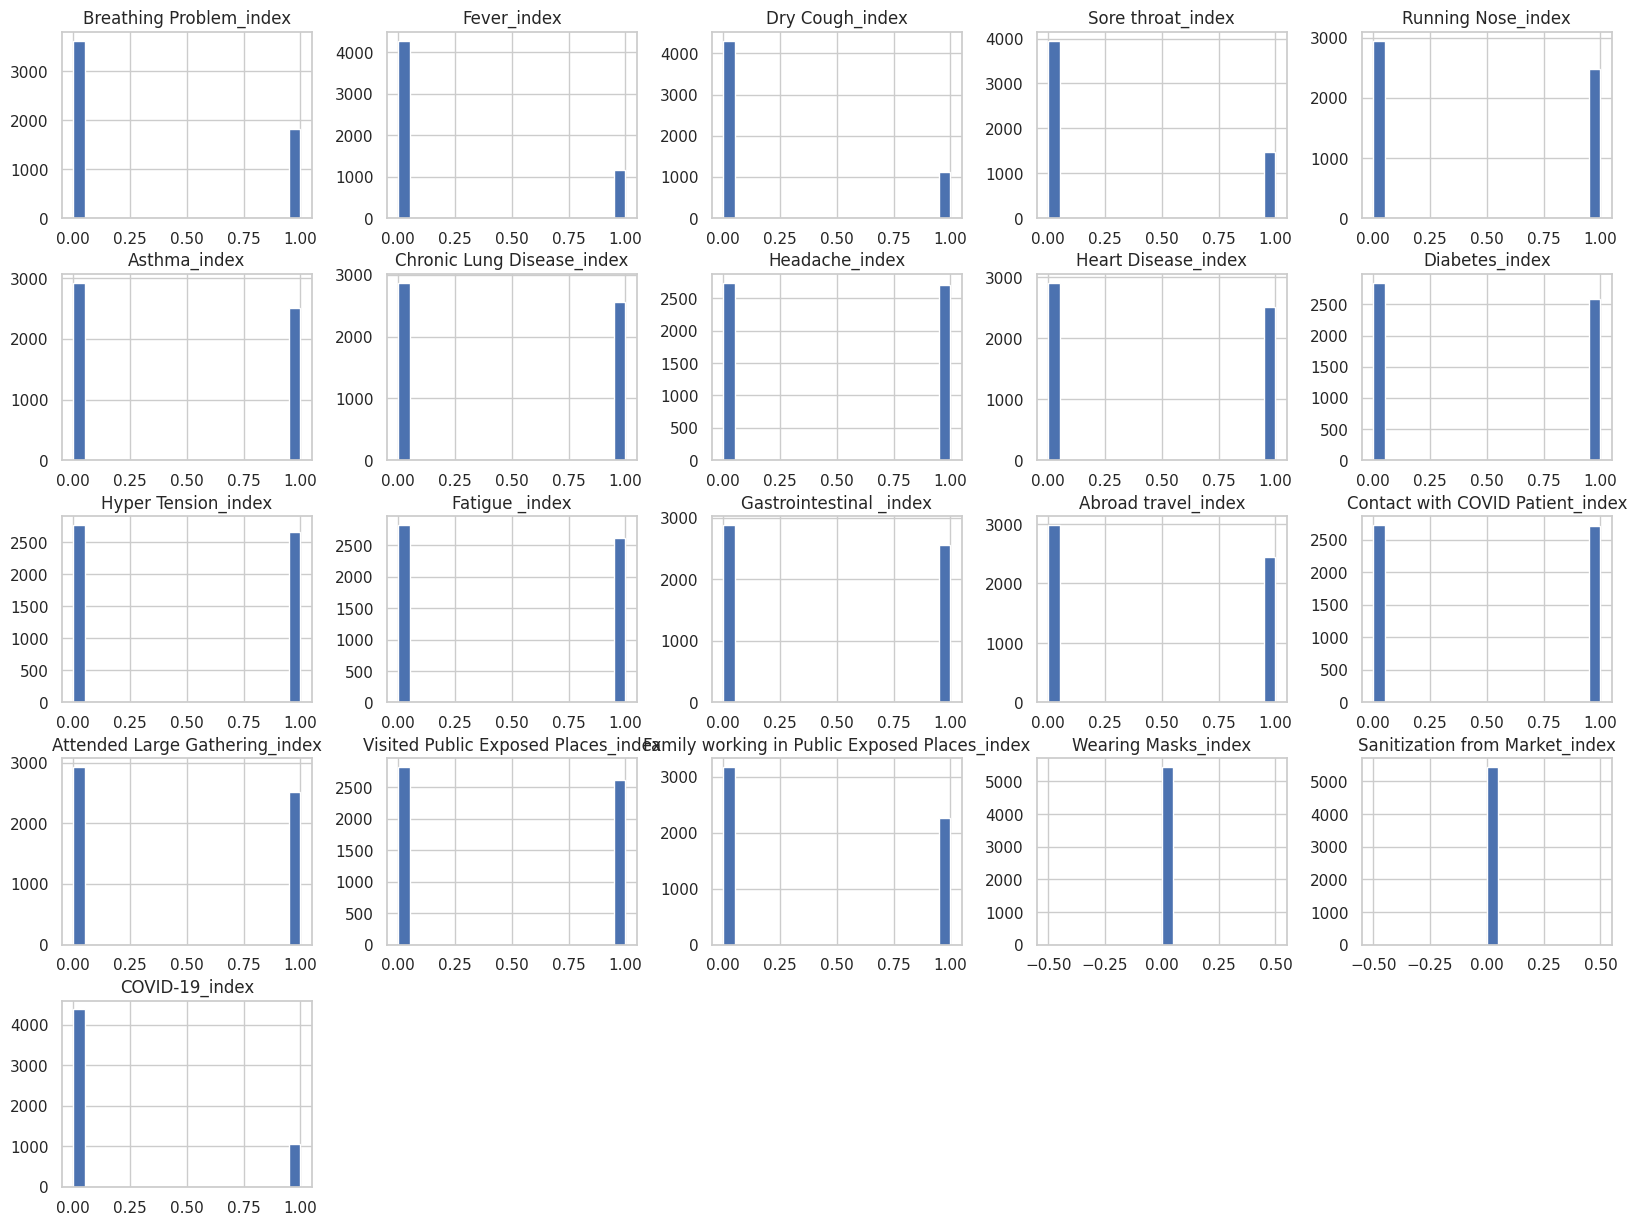

In [ ]:
# Assuming you want to plot histograms for all numerical columns
numerical_columns = [col_name for col_name, col_type in covid_data.dtypes if col_type in ['int', 'double']]

# Collect the data and convert to Pandas DataFrame
covid_data_pd = covid_data.select(numerical_columns).toPandas()

# Plotting histograms
sns.set(style="whitegrid")
covid_data_pd.hist(figsize=(20, 15), bins=20)
plt.show()

Drop unnecessary columns

   Wearing Masks_index  count
0                  0.0   5434


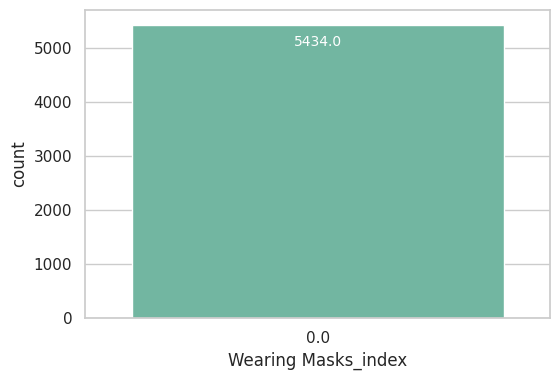

In [ ]:
# Assuming 'Wearing Masks_index' is the indexed version of 'Wearing Masks'
wearing_masks_counts = covid_data.groupBy('Wearing Masks_index').count().toPandas()

# Print value counts
print(wearing_masks_counts)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Wearing Masks_index', y='count', data=wearing_masks_counts, palette="Set2")

# Annotate each bar with the count value
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height() + 100),
                ha='center', va='top', color='white', size=10)

plt.show()

   Sanitization from Market_index  count
0                             0.0   5434


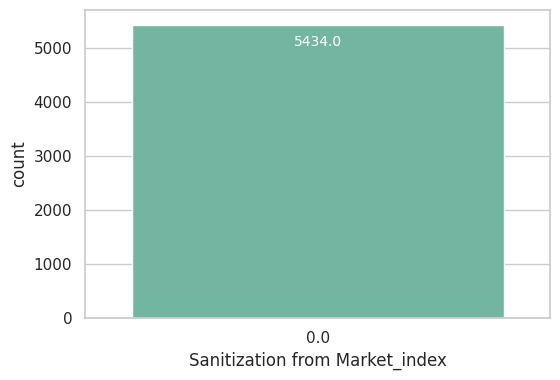

In [ ]:
# Assuming 'Sanitization from Market_index' is the indexed version of 'Sanitization from Market'
sanitization_counts = covid_data.groupBy('Sanitization from Market_index').count().toPandas()

# Print value counts
print(sanitization_counts)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
ax = sns.barplot(x='Sanitization from Market_index', y='count', data=sanitization_counts, palette="Set2")

# Annotate each bar with the count value
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x() + 0.4, p.get_height() + 100),
                ha='center', va='top', color='white', size=10)

plt.show()

In [ ]:
# Drop 'Wearing Masks' and 'Sanitization from Market' columns
columns_to_drop = ['Wearing Masks_index', 'Sanitization from Market_index']
covid_data = covid_data.drop(*columns_to_drop)

In [ ]:
# Display the features with the total number of features
feature_columns = covid_data.columns
num_features = len(feature_columns)

print("Features:")
for i, column in enumerate(feature_columns, start=1):
    print(f"{i}. {column}")

print("\nTotal number of features:", num_features)


Features:
1. Breathing Problem_index
2. Fever_index
3. Dry Cough_index
4. Sore throat_index
5. Running Nose_index
6. Asthma_index
7. Chronic Lung Disease_index
8. Headache_index
9. Heart Disease_index
10. Diabetes_index
11. Hyper Tension_index
12. Fatigue _index
13. Gastrointestinal _index
14. Abroad travel_index
15. Contact with COVID Patient_index
16. Attended Large Gathering_index
17. Visited Public Exposed Places_index
18. Family working in Public Exposed Places_index
19. COVID-19_index

Total number of features: 19


Display the correlation matrix between numerical columns

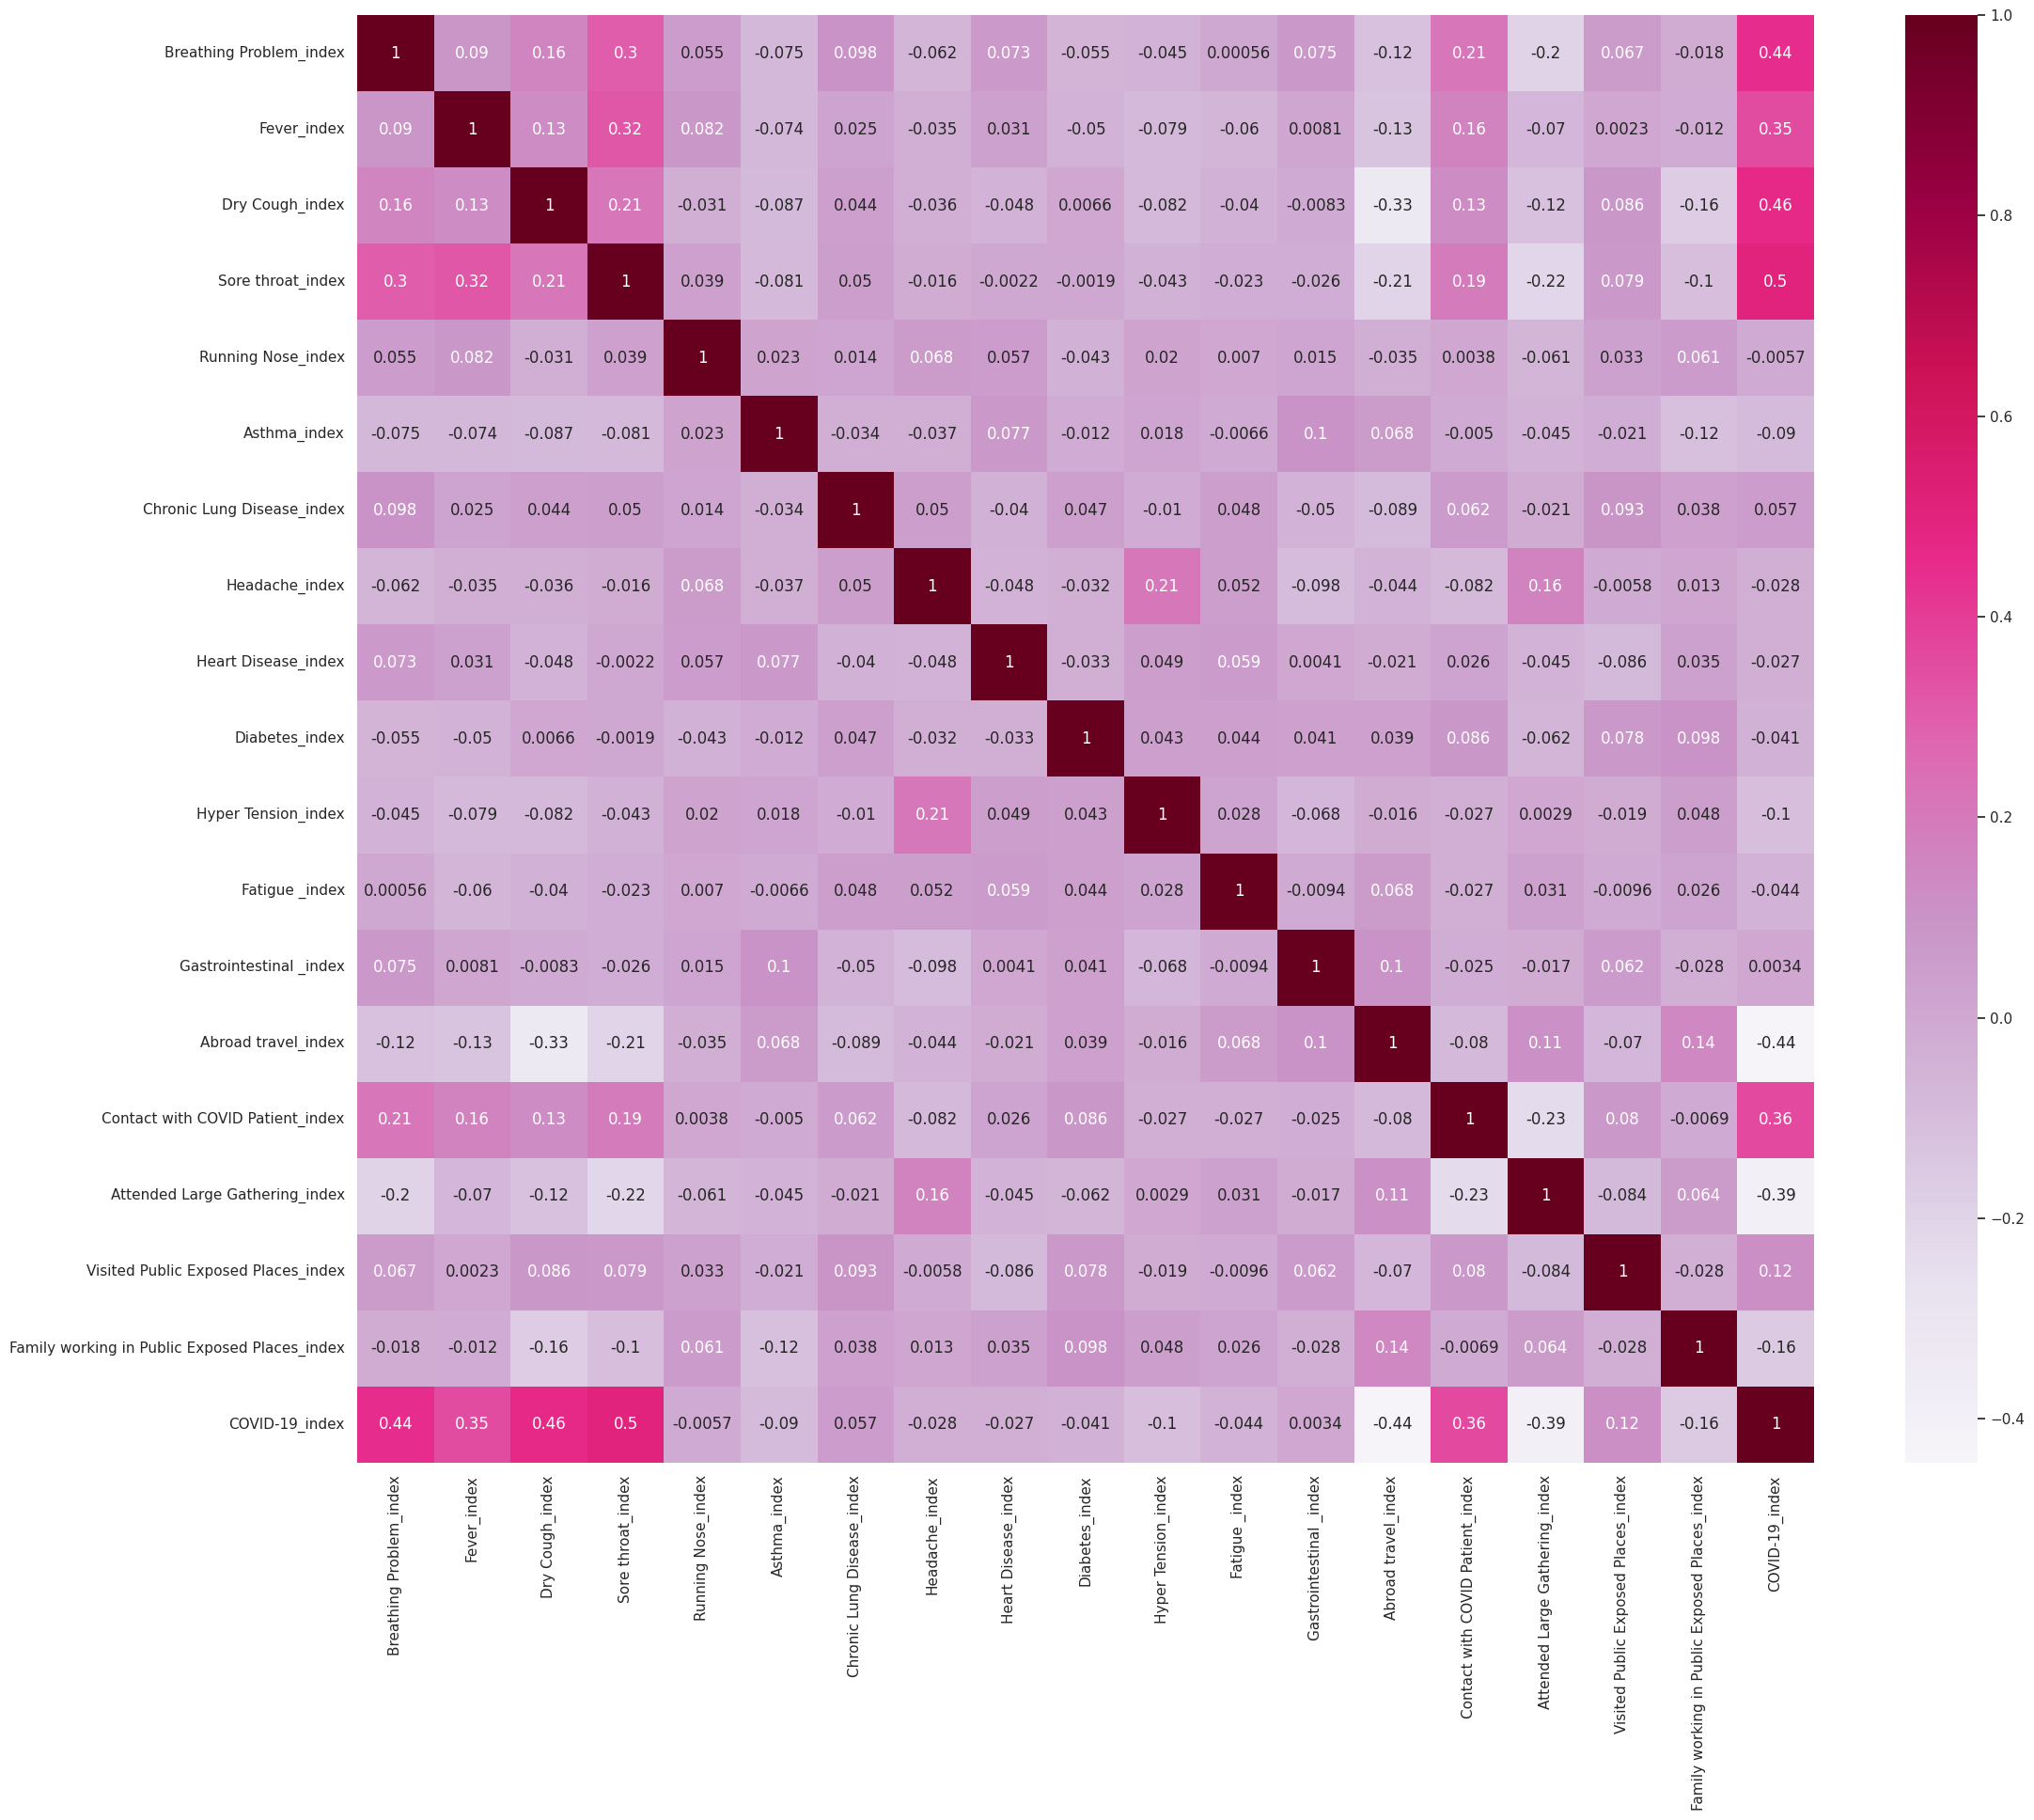

In [ ]:
# Extract numerical columns for correlation analysis
numerical_columns = [col for col, dtype in covid_data.dtypes if dtype in ['int', 'double']]

# Compute the correlation matrix
correlation_matrix = covid_data.select(numerical_columns).toPandas().corr()

# Create a heatmap using Seaborn and Matplotlib
plt.figure(figsize=(25, 20))
sns.heatmap(correlation_matrix, annot=True, cmap="PuRd")
plt.show()

Split Data

In [ ]:
# Extract feature columns (excluding the target variable 'COVID-19')
feature_columns = [col for col in covid_data.columns if col != 'COVID-19_index']

# Create a vector assembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create a PySpark StringIndexer for the target variable
label_indexer = StringIndexer(inputCol="COVID-19_index", outputCol="covid_label")


Build Models

Logistic Regression


In [ ]:
# Create a Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="covid_label", maxIter=100, regParam=0.01)

# Create a Pipeline
pipeline = Pipeline(stages=[vector_assembler, label_indexer, lr])

In [ ]:
# Split the data into training and testing sets
train_data, test_data = covid_data.randomSplit([0.8, 0.2], seed=101)

# Display the shape of the training and testing sets
print("Training Set Size:", train_data.count())
print("Testing Set Size:", test_data.count())

Training Set Size: 4340
Testing Set Size: 1094


In [ ]:
# Fit the pipeline to the training data
model = pipeline.fit(train_data)

In [ ]:
# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator for multiple metrics
evaluator = MulticlassClassificationEvaluator(labelCol="covid_label", predictionCol="prediction")

In [ ]:
# Create an evaluator for F1 score
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="COVID-19_index", predictionCol="prediction", metricName="f1")

# Calculate and print F1 score
f1_score = evaluator_f1.evaluate(predictions)
print(f"F1 Score: {f1_score}")

# Create an evaluator for recall
evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="COVID-19_index", predictionCol="prediction", metricName="weightedRecall")

# Calculate and print recall
recall = evaluator_recall.evaluate(predictions)
print(f"Recall: {recall}")

# Create an evaluator for precision
evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="COVID-19_index", predictionCol="prediction", metricName="weightedPrecision")

# Calculate and print precision
precision = evaluator_precision.evaluate(predictions)
print(f"Precision: {precision}")

# Create an evaluator for ROC-AUC
evaluator_roc_auc = BinaryClassificationEvaluator(
    labelCol="COVID-19_index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Calculate and print ROC-AUC
roc_auc = evaluator_roc_auc.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")

# Create an evaluator for mean squared error
evaluator_mse = RegressionEvaluator(
    labelCol="COVID-19_index", predictionCol="prediction", metricName="mse")

# Calculate and print mean squared error
mse = evaluator_mse.evaluate(predictions)
print(f"Mean Squared Error: {mse}")

# Create an evaluator for accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="COVID-19_index", predictionCol="prediction", metricName="accuracy")

# Calculate and print accuracy
accuracy = evaluator_accuracy.evaluate(predictions)
print(f"Accuracy: {accuracy}")

F1 Score: 0.9653331891681749
Recall: 0.9661791590493601
Precision: 0.9662075332454287
ROC-AUC: 0.9876090684146553
Mean Squared Error: 0.03382084095063985
Accuracy: 0.9661791590493601


In [ ]:
# Create a confusion matrix
confusion_matrix = predictions.groupBy("COVID-19_index", "prediction").count()

# Print the confusion matrix
confusion_matrix.show()

+--------------+----------+-----+
|COVID-19_index|prediction|count|
+--------------+----------+-----+
|           1.0|       1.0|  177|
|           0.0|       1.0|    6|
|           1.0|       0.0|   31|
|           0.0|       0.0|  880|
+--------------+----------+-----+



Random Forest


In [ ]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="covid_label", numTrees=100)

# Create a pipeline with StringIndexer, VectorAssembler, and RandomForest
pipeline_rf = Pipeline(stages=[label_indexer, vector_assembler, rf])


In [ ]:
# Fit the pipeline to the training data
model_rf = pipeline_rf.fit(train_data)

In [ ]:
# Make predictions on the test data
predictions_rf = model_rf.transform(test_data)

# Evaluate the model
evaluator_rf = BinaryClassificationEvaluator(labelCol="covid_label", metricName="areaUnderROC")
roc_auc_rf = evaluator_rf.evaluate(predictions_rf)

# Print ROC-AUC value
print(f"ROC-AUC: {roc_auc_rf}")

ROC-AUC: 0.990832284250738


In [ ]:
# Create an evaluator for accuracy
rf_evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="COVID-19_index", predictionCol="prediction", metricName="accuracy")

# Calculate and print accuracy
accuracy_rf = rf_evaluator_accuracy.evaluate(predictions_rf)
print(f"Accuracy: {accuracy_rf}")

Accuracy: 0.9606946983546618


In [ ]:
# Create a confusion matrix
rf_confusion_matrix = predictions_rf.groupBy("COVID-19_index", "prediction").count()

# Print the confusion matrix
rf_confusion_matrix.show()

+--------------+----------+-----+
|COVID-19_index|prediction|count|
+--------------+----------+-----+
|           1.0|       1.0|  165|
|           1.0|       0.0|   43|
|           0.0|       0.0|  886|
+--------------+----------+-----+



Save models

In [ ]:

# Save the model to disk
model.save("path/to/save_model")

# Load the model back later
loaded_model = PipelineModel.load("path/to/save_model")

In [ ]:
pip install joblib


Print Results

In [ ]:

# Close Spark session
spark.stop()